# EYE FOR BLIND - Capstone Project

### By: Dinesh Vhatte

### Importing  all required libraries

In [1]:
#Import all the required libraries
import glob
from PIL import Image
import pandas as pd
import numpy as np
from functools import reduce
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import ImageFont
from PIL import ImageDraw 
import seaborn as sns
from pickle import dump,load
import time

import keras
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from keras.preprocessing import sequence
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D

from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

Let's read the dataset

## Data Understanding
    1.Import the dataset and read image & captions into two seperate variables
    2.Visualise both the images & text present in the dataset
    3.Create word-to-index and index-to-word mappings.
    4.Create a dataframe which summarizes the image, path & captions as a dataframe
    5.Visualise the top 30 occuring words in the captions
    6.Create a list which contains all the captions & path

### 1.Import the dataset and read image & captions into two seperate variables

In [2]:
#Import the dataset and read the image into a seperate variable

images='Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


### 2.Visualise both the images & text present in the dataset

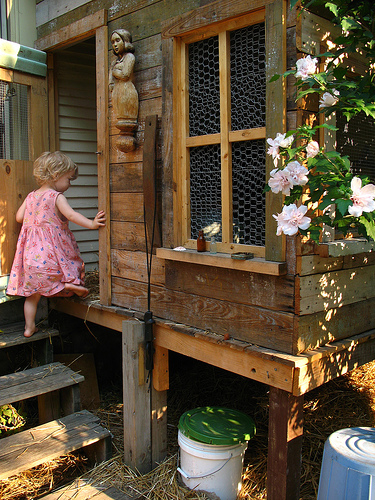

In [3]:
#Visualise both the images & text present in the dataset
Image.open(all_imgs[0])

In [4]:
all_imgs[0]

'Images/1000268201_693b08cb0e.jpg'

### 3.Create word-to-index and index-to-word mappings.

In [5]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    text=open(filename).read()
    
    return text

def get_img_ids_and_captions(text):
    keys=[]
    values=[]
    key_paths=[]
    text=text.splitlines()[1:]
    for line in text:
        com_idx=line.index(",")
        im_id,im_cap=line[:com_idx],line[com_idx+1:]
        keys.append(im_id)
        values.append(im_cap)
        key_paths.append(images+'/'+im_id)
    return keys,values,key_paths

text_file="captions.txt"
# text_file = 'D:/upGrad_Data_Science/Capstone - Eye for blind/Flickr8K/captions.txt'
doc = load_doc(text_file)
print(doc[:600], "........")

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7 ........


### 4.Create a dataframe which summarizes the image, path & captions as a dataframe

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [6]:
all_img_id,annotations,all_img_vector= get_img_ids_and_captions(doc)#store all the image id here


df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


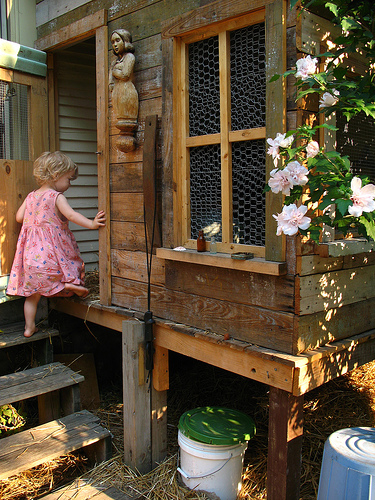

In [7]:
Image.open(all_img_vector[0])

In [8]:
#Create the vocabulary & the counter for the captions
def voc_fetcher(frame,column):
    out=[]
    for i in frame[column]:
        out+=i.split(" ")
    return out


vocabulary=voc_fetcher(df,"Captions")
val_count=Counter(vocabulary)
val_count

Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

### 5.Visualise the top 30 occuring words in the captions

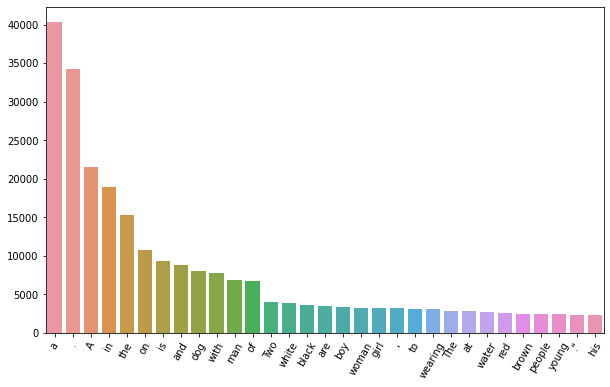

In [9]:
#Visualise the top 30 occuring words in the captions
def get_top_words_based_on_cnt(words_dict,n_words):
    n_words+=1
    keys=list(words_dict.keys())
    values=list(words_dict.values())
    sorted_values=sorted(values,reverse=True)[:n_words]
    sorted_keys=[]
    for i in sorted_values:
        if sorted_values.count(i)==1:
            sorted_keys.append(keys[values.index(i)])
        elif sorted_values.count(i)==2:
            f_idx=values.index(i)
            s_idx=values[f_idx+1:].index(i)
            s_idx+=f_idx+1
            a,b=keys[f_idx],keys[s_idx]
            if a not in sorted_keys and b not in sorted_keys:
                sorted_keys.append(a)
                sorted_keys.append(b)
    plt.figure(figsize=(10,6))
    sns.barplot(x=sorted_keys,y=sorted_values)
    plt.xticks(rotation=60)
    plt.show()
    #write your code here
get_top_words_based_on_cnt(val_count,30)

### 6.Create a list which contains all the captions & path

In [10]:
#Create a list which contains all the captions
annotations=df.Captions.apply(lambda z:"<start>"+" "+z+" "+"<end>")

#add the <start> & <end> token to all those captions as well


#Create a list which contains all the path to the images
all_img_path=df.Path.to_list()#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


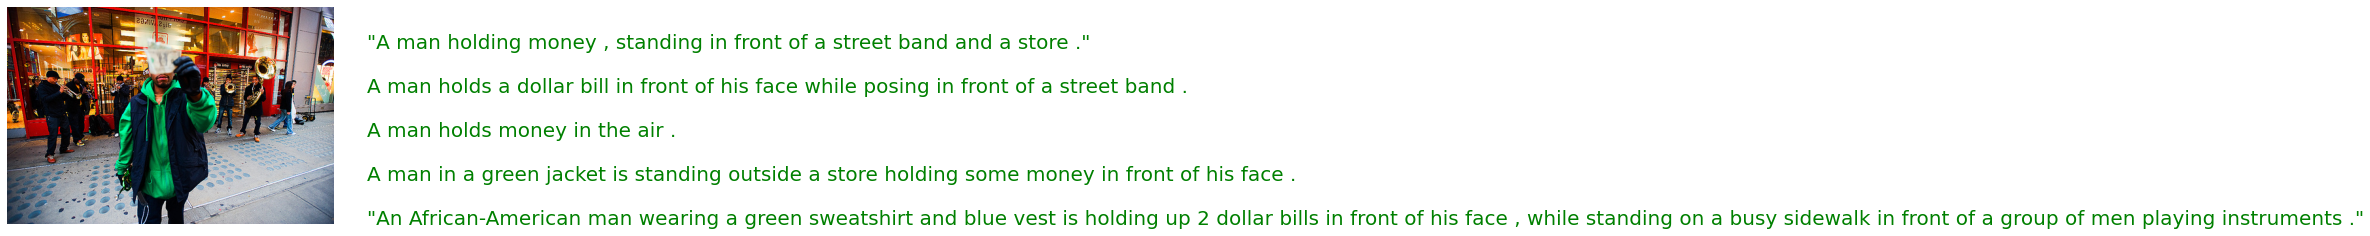

In [11]:
def caption_and_image_plotter(image_id,frame):
    #get captions
    caps=("\n"*2).join(frame[frame['ID']==image_id].Captions.to_list())
    fig, ax = plt.subplots()
    ax.set_axis_off()
    idx=df.ID.to_list().index(image_id)
    im=Image.open(df.Path.iloc[idx])
    w,h=im.size[0],im.size[-1]
    ax.imshow(im)
    ax.text(w+50,h,caps,fontsize=20,color='green')
caption_and_image_plotter(df.ID.iloc[8049],df)

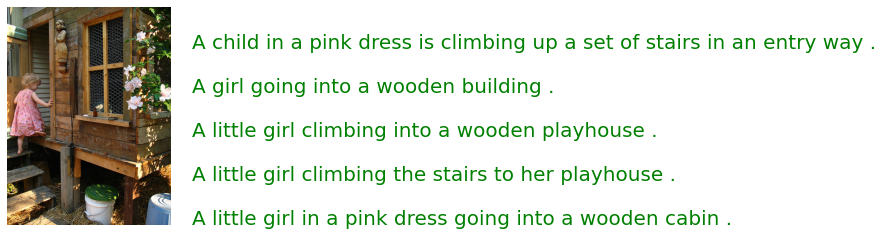

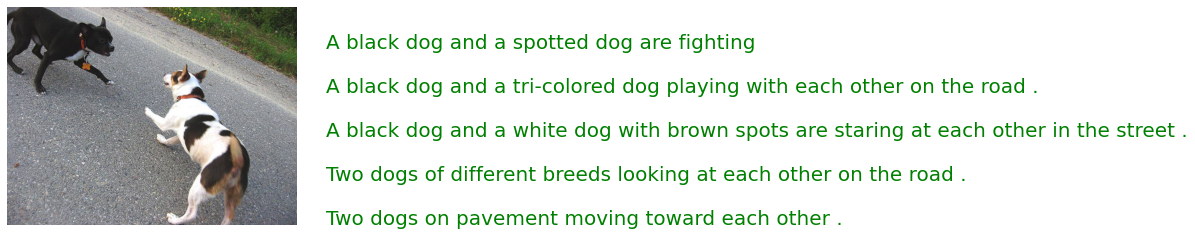

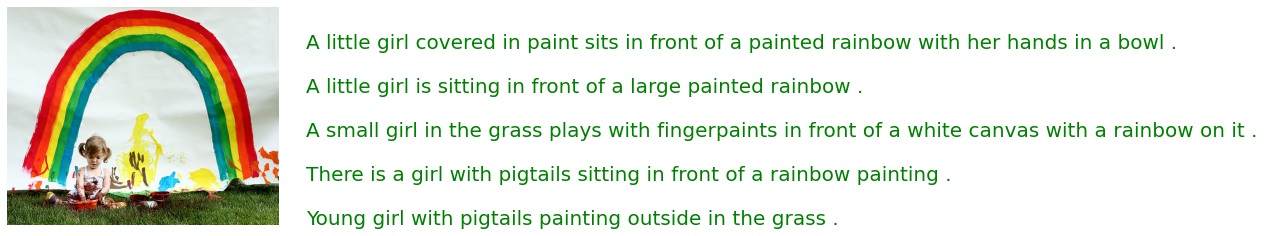

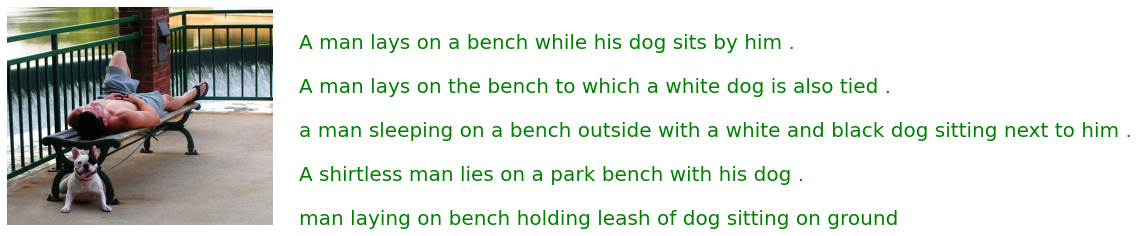

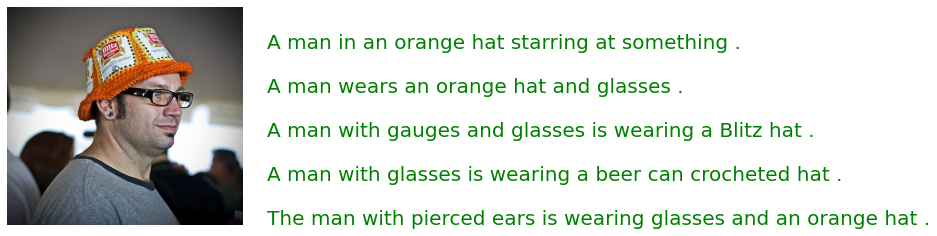

In [12]:
def run_caption_and_image_plotter_for_a_range(start,end,frame):
    for i in range(start,end):
        caption_and_image_plotter(frame.ID.drop_duplicates().iloc[i],frame)
run_caption_and_image_plotter_for_a_range(0,5,df)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [13]:
# create the tokenizer
top_word_cnt = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_cnt,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

In [14]:
train_seqs[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [15]:
# Create word-to-index and index-to-word mappings.
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(annotations)

In [16]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('a', 62992),
             ('child', 1545),
             ('in', 18986),
             ('pink', 739),
             ('dress', 348),
             ('is', 9345),
             ('climbing', 507),
             ('up', 1302),
             ('set', 109),
             ('of', 6723),
             ('stairs', 109),
             ('an', 2432),
             ('entry', 1),
             ('way', 53),
             ('<end>', 40455),
             ('girl', 3328),
             ('going', 149),
             ('into', 1074),
             ('wooden', 284),
             ('building', 510),
             ('little', 1768),
             ('playhouse', 6),
             ('the', 18419),
             ('to', 3176),
             ('her', 1178),
             ('cabin', 4),
             ('black', 3848),
             ('dog', 8138),
             ('and', 8862),
             ('spotted', 38),
             ('are', 3504),
             ('fighting', 133),
             ('tri', 14),
             ('color

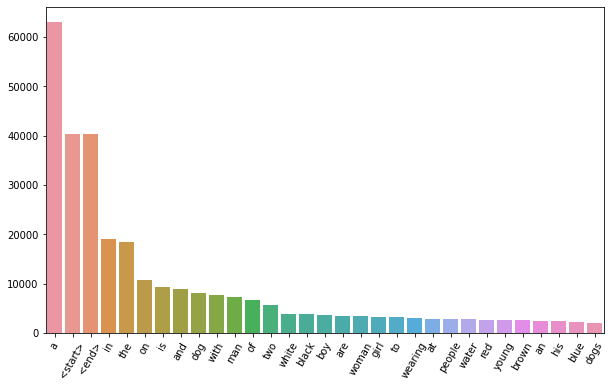

In [17]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
get_top_words_based_on_cnt(tokenizer.word_counts,30)

In [18]:
def min_max_for_nested_array(nested_array):
    array=[len(e) for e in nested_array]
    return min(array),max(array)
min_l,max_l=min_max_for_nested_array(train_seqs)

In [19]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

cap_vector=tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding='post',maxlen=max_l)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

In [20]:
#write your code here
def load_the_image(file_path):
    my_img = tf.io.read_file(file_path)
    my_img = tf.image.decode_jpeg(my_img, channels=3)
    my_img = tf.image.resize(my_img, (299, 299))
    my_img = tf.keras.applications.inception_v3.preprocess_input(my_img)
    return my_img,file_path

2024-06-15 18:06:13.408774: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-06-15 18:06:13.408845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9882 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


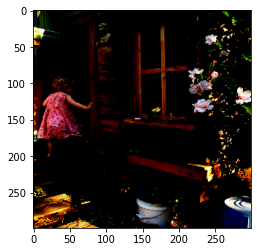

In [21]:
plt.imshow(load_the_image(all_img_path[0])[0])

In [22]:
encode_train_set = sorted(set(all_img_vector))

feature_dict = {}

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(load_the_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

In [23]:
image_data_set

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)

In [24]:
#write your code here
image_train, image_test, caption_train, caption_test = train_test_split(all_img_vector,
                                                                        cap_vector,
                                                                        test_size=0.2,
                                                                        random_state=33)

In [25]:
print("Training data for images: " + str(len(image_train)))
print("Testing data for images: " + str(len(image_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [26]:
def map_function(image_name,capt):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,capt

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)

In [27]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input 
hidden_layer = image_model.layers[-1].output 

image_features_extract_model = keras.Model(new_input, hidden_layer) 

In [28]:
# write your code to extract features from each image in the dataset
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [29]:
for image,path in tqdm(image_data_set):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [00:39<00:00,  6.34it/s]


In [30]:
batch_f.shape

TensorShape([64, 2048])

In [31]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def generate_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [32]:
train_dataset=generate_dataset(image_train,caption_train)
test_dataset=generate_dataset(image_test,caption_test)

In [33]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [34]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(image_train) // BATCH_SIZE
test_num_steps = len(image_test) // BATCH_SIZE

### Encoder

In [35]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.fc = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(0.5)
        
    def call(self, features):
        features = self.fc(features)
        features = tf.nn.relu(features)
        return features

In [36]:
encoder=Encoder(embedding_dim)

### Attention model

In [37]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights =  keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        return context_vector, attention_weights

In [38]:
class RNN_Decoder(Model):
    def __init__(self, embedding_dim, units, vocab_size):

        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size)

        self.attention = Attention_model(self.units)

    def call(self, x, features, hidden):
    # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

### Decoder

In [39]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=False)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)
        self.d2 = layers.Dense(vocab_size)   
        self.dropout = Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed = self.dropout(self.embed(x)) 
        mask = self.embed.compute_mask(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed,mask=mask)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) 
        output = self.d2(output) 

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [40]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [41]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) 
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) 
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [42]:
optimizer = Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [43]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [44]:
checkpoint_path = "flickr8k/File4/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,
                                          checkpoint_path,
                                          max_to_keep=5)

In [45]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [46]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, avg_loss

In [47]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, avg_loss

In [48]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [49]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|▋         | 1/15 [04:55<1:09:03, 295.97s/it]

For epoch: 1, the train loss is 1.192, & test loss is 1.003
Time taken for 1 epoch 295.78908252716064 sec

Test loss has been reduced from 100.000 to 1.003
For epoch: 2, the train loss is 0.940, & test loss is 0.889
Time taken for 1 epoch 158.5360996723175 sec

Test loss has been reduced from 1.003 to 0.889


 13%|█▎        | 2/15 [07:34<46:38, 215.27s/it]  

For epoch: 3, the train loss is 0.855, & test loss is 0.819
Time taken for 1 epoch 155.6958727836609 sec

Test loss has been reduced from 0.889 to 0.819


 20%|██        | 3/15 [10:10<37:38, 188.18s/it]

For epoch: 4, the train loss is 0.794, & test loss is 0.764
Time taken for 1 epoch 159.3265037536621 sec

Test loss has been reduced from 0.819 to 0.764


 27%|██▋       | 4/15 [12:50<32:25, 176.89s/it]

For epoch: 5, the train loss is 0.743, & test loss is 0.718
Time taken for 1 epoch 159.51998496055603 sec

Test loss has been reduced from 0.764 to 0.718


 33%|███▎      | 5/15 [15:30<28:27, 170.71s/it]

For epoch: 6, the train loss is 0.699, & test loss is 0.676
Time taken for 1 epoch 157.95897817611694 sec

Test loss has been reduced from 0.718 to 0.676


 40%|████      | 6/15 [18:08<24:58, 166.47s/it]

For epoch: 7, the train loss is 0.659, & test loss is 0.638
Time taken for 1 epoch 158.21777200698853 sec

Test loss has been reduced from 0.676 to 0.638


 47%|████▋     | 7/15 [20:46<21:50, 163.87s/it]

For epoch: 8, the train loss is 0.622, & test loss is 0.603
Time taken for 1 epoch 154.8609426021576 sec

Test loss has been reduced from 0.638 to 0.603


 53%|█████▎    | 8/15 [23:21<18:47, 161.08s/it]

For epoch: 9, the train loss is 0.589, & test loss is 0.568
Time taken for 1 epoch 158.7789409160614 sec

Test loss has been reduced from 0.603 to 0.568


 60%|██████    | 9/15 [26:00<16:02, 160.43s/it]

For epoch: 10, the train loss is 0.558, & test loss is 0.539
Time taken for 1 epoch 159.70351600646973 sec

Test loss has been reduced from 0.568 to 0.539


 67%|██████▋   | 10/15 [28:40<13:21, 160.30s/it]

For epoch: 11, the train loss is 0.530, & test loss is 0.512
Time taken for 1 epoch 164.73320603370667 sec

Test loss has been reduced from 0.539 to 0.512


 73%|███████▎  | 11/15 [31:25<10:46, 161.73s/it]

For epoch: 12, the train loss is 0.504, & test loss is 0.487
Time taken for 1 epoch 162.2250258922577 sec

Test loss has been reduced from 0.512 to 0.487


 80%|████████  | 12/15 [34:08<08:05, 161.97s/it]

For epoch: 13, the train loss is 0.481, & test loss is 0.464
Time taken for 1 epoch 167.69682574272156 sec

Test loss has been reduced from 0.487 to 0.464


 87%|████████▋ | 13/15 [36:56<05:27, 163.77s/it]

For epoch: 14, the train loss is 0.460, & test loss is 0.445
Time taken for 1 epoch 171.62271571159363 sec

Test loss has been reduced from 0.464 to 0.445


 93%|█████████▎| 14/15 [39:48<02:46, 166.23s/it]

For epoch: 15, the train loss is 0.441, & test loss is 0.428
Time taken for 1 epoch 163.8760917186737 sec

Test loss has been reduced from 0.445 to 0.428


100%|██████████| 15/15 [42:32<00:00, 170.16s/it]


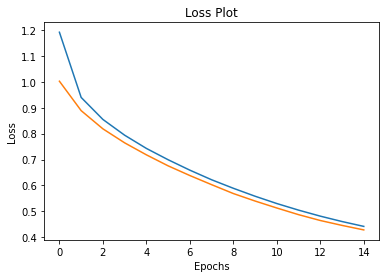

In [50]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [51]:
def evaluate(image):
    max_length=max_l
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_the_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

### Beam Search(optional)

In [52]:
def beam_evaluate(image, beam_index = 3):
    max_length=max_l
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_the_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [53]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [54]:
from nltk.translate.bleu_score import sentence_bleu

In [55]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [56]:
import numpy as np

In [57]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

## Evaluation with Unseen Data

4104
BLEU score: 60.653065971263345
Real Caption: a man in a red kayak through a wave
Prediction Caption: a man in a red kayak


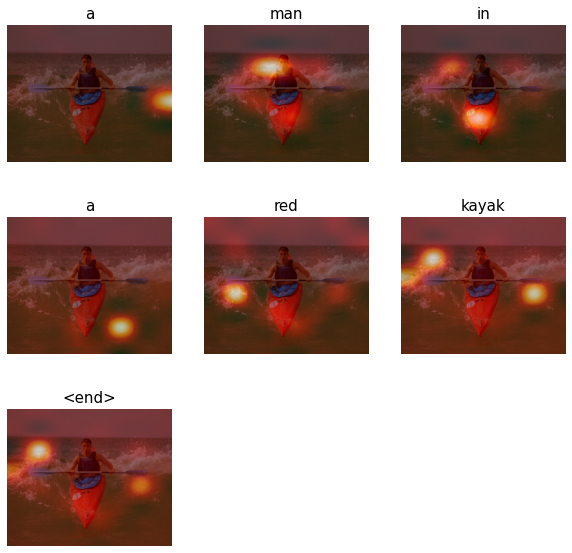

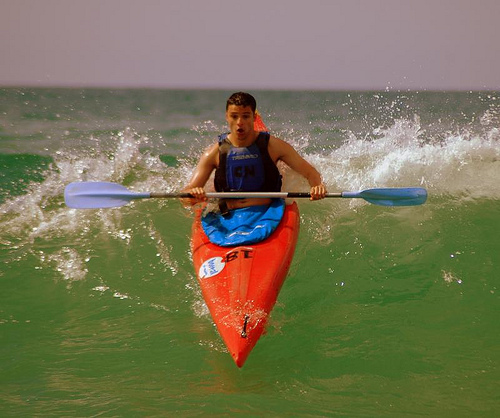

In [65]:
rid = np.random.randint(0, len(image_test))
print(rid)
test_image = image_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(f"BLEU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [66]:
captions=beam_evaluate(test_image)
print(pred_caption)

a man in a red kayak


## Converting Text to Speech

In [67]:
! pip install gTTS

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [69]:
# Import the required module for text to speech conversion
from gtts import gTTS
import os
# Language in which you want to convert
language = 'en'
  
# Passing the text and language to the engine, 
myobj = gTTS(text=pred_caption, lang=language, slow=False)
  
# Saving the converted audio in a mp3 file named
myobj.save("Predicted_text.mp3")

-----------------------------------------------------------CODE COMPLETE. THANK YOU!-----------------------------------------------------